In [1]:
# split train and test set of math symbols
import json
import random
import os

random.seed(777)

symbol_images_dir = 'symbol_images/'
terminals = ['+', '-', 'times', 'div', '!'] + list(map(str, list(range(10))))
sym_train_set = {}
sym_val_set = {}
sym_test_set = {}
for tok in terminals:
    imgs = os.listdir(symbol_images_dir + tok)
    random.shuffle(imgs)
    n_train = int(len(imgs) * 0.75)
    n_val = int(len(imgs) * 0.05)
    sym_train_set[tok] = sorted(imgs[:n_train])
    sym_val_set[tok] = sorted(imgs[n_train:n_train+n_val])
    sym_test_set[tok] = sorted(imgs[n_train+n_val:])
    print(tok, len(imgs))
json.dump(sym_train_set, open('sym_train.json', 'w'))
json.dump(sym_val_set, open('sym_val.json', 'w'))
json.dump(sym_test_set, open('sym_test.json', 'w'))

+ 25112
- 33997
times 3251
div 868
! 1300
0 6914
1 26520
2 26141
3 10909
4 7396
5 3545
6 3118
7 2909
8 3068
9 3737


In [2]:
import os
import random
from PIL import Image
import json

sym_train_set = json.load(open('sym_train.json'))
sym_val_set = json.load(open('sym_val.json'))
sym_test_set = json.load(open('sym_test.json'))

def render_img(img_paths):
    images = [Image.open(symbol_images_dir + x) for x in img_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

def generate_img_paths(tokens, sym_set=sym_train_set, render_img = False):
    img_paths = []
    for tok in tokens:
        if tok == '*': tok = 'times'
        if tok == '/': tok = 'div'
        
        img_name = random.choice(sym_set[tok])
        img_paths.append(os.path.join(tok, img_name))   
        
    return img_paths

In [3]:
import math
import random
from tqdm import *
import re

random.seed(777)

min_num = 0
max_num = 10
num_list = list(map(str, range(min_num, max_num)))
nonzero_num_list = [x for x in num_list if x != '0']
op_list = ['+', '-', '*', '/', '!']
nonfactorial_op_list = ['+', '-', '*', '/']

print(num_list)
print(op_list)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['+', '-', '*', '/', '!']


In [4]:
from domain import SYM2PROG
import sys
sys.path.insert(0, "..")
from jointer import AST

def eval_expr(expr, head):
    ast = AST(expr, head, SYM2PROG)
    return ast.res()

In [5]:
def generate_expression(n_op):
    expr = [random.choice(num_list)]
    for _ in range(n_op):
        if expr[-1] == '!': ## disallow two consecutive ! to avoid overflow
            selected_op = random.choice(nonfactorial_op_list)
        else:
            selected_op = random.choice(op_list)
        if selected_op == '//' or selected_op == '/':
            selected_num = random.choice(nonzero_num_list)
        elif selected_op == '!':
            selected_num = ""
        else:
            selected_num = random.choice(num_list)
        expr.append(selected_op)
        if selected_num != "":
            expr.append(selected_num)
    return expr

def eval_expr_by_eval(expr):
    expr_for_eval = []
    for symbol in expr:
        if symbol == '!':
            expr_for_eval[-1] = 'math.factorial(' + expr_for_eval[-1] + ')'
        elif symbol == '/':
            expr_for_eval.append('//')
        else:
            expr_for_eval.append(symbol)
#     try:
#         res = eval("".join(expr_for_eval))
#     except OverflowError:
#         res = None
    res = eval("".join(expr_for_eval))
    return res

def parse_expr(expr):
    values = []
    operators = []
    priority = {'+': 0, '-': 0, '*': 1, '/': 1, '!': 2}
    arity = {'+': 2, '-': 2, '*': 2, '/': 2, '!': 1}

    head = [-1] * len(expr)
    for (i,sym) in enumerate(expr):
        if sym.isdigit():
            values.append(i)
        else:
            while len(operators) > 0 and priority[expr[operators[-1]]] >= priority[sym]:
                op = operators.pop()
                for _ in range(arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            operators.append(i)

    while len(operators) > 0:
        op = operators.pop()
        for _ in range(arity[expr[op]]):
            head[values.pop()] = op
        values.append(op)

    
    root_op = values.pop()
    head[root_op] = -1
    assert len(values) == 0

    return head

expr = '6/4+2!'
head = parse_expr(expr)
res = eval_expr(expr, head)
print(expr, res, head)

6/4+2! 3 [1, 3, 1, -1, 5, 3]


In [6]:
# generate train set
max_op = 3
n_per_level = 1000
sym_set = sym_train_set
split = 'train'

expr_list = []
idx = 0
for n_op in range(max_op+1):
    n_samples = 2**n_op * n_per_level
    for _ in trange(n_samples):
        expr = generate_expression(n_op)
        head = parse_expr(expr)
        res = eval_expr(expr, head)
        if res is None:
            print(expr)
            continue
        img_paths = generate_img_paths(expr, sym_set=sym_set, render_img=True)
        sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                  'expr': expr, 'head': head, 'res': res}
        idx += 1
        expr_list.append(sample)
print(len(expr_list))

expr_train_set = expr_list


# generate val set
max_op = 3
n_per_level = 100
sym_set = sym_val_set
split = 'val'

expr_list = []
idx = 0
for n_op in range(max_op+1):
    n_samples = 2**n_op * n_per_level
    for _ in trange(n_samples):
        expr = generate_expression(n_op)
        head = parse_expr(expr)
        res = eval_expr(expr, head)
        if res is None:
            print(expr)
            continue
        img_paths = generate_img_paths(expr, sym_set=sym_set, render_img=True)
        sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                  'expr': expr, 'head': head, 'res': res}
        idx += 1
        expr_list.append(sample)
print(len(expr_list))
expr_val_set = expr_list

# generate test set
max_op = 9
n_per_level = 10000
sym_set = sym_test_set
split = 'test'

expr_list = []
idx = 0
for n_op in range(max_op+1):
    n_samples = n_per_level
    for _ in trange(n_samples):
        expr = generate_expression(n_op)
        head = parse_expr(expr)
        res = eval_expr(expr, head)
        if res is None:
            print(expr)
            continue
        img_paths = generate_img_paths(expr, sym_set=sym_set, render_img=True)
        sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                  'expr': expr, 'head': head, 'res': res}
        idx += 1
        expr_list.append(sample)
print(len(expr_list))
expr_test_set = expr_list

  0%|          | 0/10000 [00:00<?, ?it/s]

15000
1500


100%|██████████| 10000/10000 [00:00<00:00, 12102.31it/s]

100000


In [7]:
json.dump(expr_train_set, open('expr_train.json', 'w'))
json.dump(expr_val_set, open('expr_val.json', 'w'))
json.dump(expr_test_set, open('expr_test.json', 'w'))

15000 100000
8/2/5+2 [1, 3, 1, 5, 3, -1, 5] 2


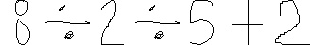

9-0!*4 [1, -1, 3, 4, 1, 4] 5


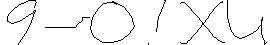

0 [-1] 0


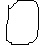

3-7+0-7 [1, 3, 1, 5, 3, -1, 5] 0


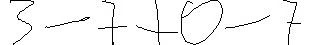

5+0 [1, -1, 1] 5


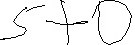

3!*9! [1, 2, -1, 4, 2] 2177280


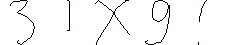

5/1-5 [1, 3, 1, -1, 3] 0


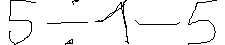

9+4*8-8 [1, 5, 3, 1, 3, -1, 5] 33


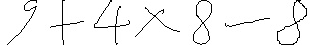

3+1+2 [1, 3, 1, -1, 3] 6


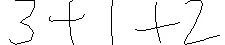

0!+6! [1, 2, -1, 4, 2] 721


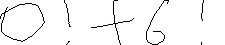

7*4/5 [1, 3, 1, -1, 3] 5


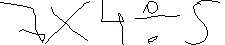

In [14]:
# Visualize data
print(len(expr_train_set), len(expr_test_set))
for _ in range(5):
    sample = random.choice(expr_train_set)
    img_paths = sample['img_paths']
    img = render_img(img_paths)
    print("".join(sample['expr']), sample['head'], sample['res'])
    display(img)

    sample = random.choice(expr_val_set)
    img_paths = sample['img_paths']
    img = render_img(img_paths)
    print("".join(sample['expr']), sample['head'], sample['res'])
    display(img)

sample = random.choice(expr_test_set)
img_paths = sample['img_paths']
img = render_img(img_paths)
print("".join(sample['expr']), sample['head'], sample['res'])
display(img)

In [9]:
import numpy as np
print(np.max([x['res'] for x in expr_train_set]))
print(np.max([x['res'] for x in expr_val_set]))
print(np.max([x['res'] for x in expr_test_set]))

131681894400
4838400
95569451679744000


In [10]:
expr_test_set[-1000]

{'id': 'test_00099000',
 'img_paths': ['4/exp39457.jpg',
  '+/exp60361.jpg',
  '5/exp44075.jpg',
  'div/exp50433.jpg',
  '2/exp12755.jpg',
  '+/+_98971.jpg',
  '5/exp78147.jpg',
  'div/exp2033.jpg',
  '1/exp19242.jpg',
  '+/exp12118.jpg',
  '2/exp94900.jpg',
  'div/exp50883.jpg',
  '8/exp25190.jpg',
  '+/exp96214.jpg',
  '0/0_4243.jpg',
  'times/exp44089.jpg',
  '3/3_80449.jpg',
  '!/exp20297.jpg'],
 'expr': ['4',
  '+',
  '5',
  '/',
  '2',
  '+',
  '5',
  '/',
  '1',
  '+',
  '2',
  '/',
  '8',
  '+',
  '0',
  '*',
  '3',
  '!'],
 'head': [1, 5, 3, 1, 3, 9, 7, 5, 7, 13, 11, 9, 11, -1, 15, 13, 17, 15],
 'res': 11}

(45, 45)


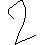

In [11]:
img = Image.open(symbol_images_dir + '2/2_849.jpg')
print(img.size)
display(img)

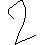

In [12]:
img.convert('L')

7/1/7-2 = -1.0


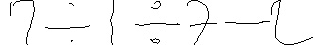

In [13]:
expr = '7/1/7-2'
img_paths = generate_img_paths(expr, sym_set=sym_set, render_img=True)
img = render_img(img_paths)
print(expr,'=', eval(expr))
display(img)